# AZ_Lyrics Complementary Database
#### Imports

In [188]:
import pandas as pd
import re
import json
import csv
import numpy as np
import os.path
# Data Source: https://www.kaggle.com/datasets/albertsuarez/azlyrics?resource=download

In [189]:
#os.chdir('../data/kaggle/')

for i in list(os.walk('.'))[0][2]: # Clean up file names for easy access
    j = i[-5:]
    os.rename(i,j)

In [190]:
AZ_Lyrics = pd.DataFrame(columns=['ARTIST_NAME', 'ARTIST_URL', 'SONG_NAME', 'SONG_URL', 'LYRICS'])

for i in list(os.walk('.'))[0][2]: # Load up all the files to the same database 
    with open(i) as fp:
        x = csv.DictReader(fp)
        y = pd.DataFrame(x)
        y[None] = y[None].fillna('').astype(str)
        y['LYRICS'] = y['LYRICS'] + y[None]
        y = y.drop(columns=[None])
        AZ_Lyrics = pd.concat([AZ_Lyrics,y],ignore_index=True)
        
AZ_Lyrics = AZ_Lyrics.rename(columns={AZ_Lyrics.columns[i]:list(map(lambda x : x.lower() , AZ_Lyrics.columns ))[i] for i in range(len(AZ_Lyrics.columns)) })

def clean(x): # Helper function for cleaning
    if type(x) != str:
        return pd.NA
    y = re.sub('\'s','',x)
    y = re.sub('[^A-Za-z0-9 ]+', '', x)
    y = y.split()
    word_set = set(y)
    return word_set

# Cleaning the database
AZ_Lyrics['lyrics'] = AZ_Lyrics['lyrics'].apply(clean)
AZ_Lyrics.dropna(axis = 0,inplace=True)
AZ_Lyrics['artist_name'] = AZ_Lyrics['artist_name'].apply(lambda x : x.strip().replace(' ','_'))
AZ_Lyrics['unique_words'] = AZ_Lyrics['lyrics'].apply(lambda x : len(x))
AZ_Lyrics = AZ_Lyrics.reset_index()

### Extracting unique lyrics

In [191]:
artist_dict = {}
for i in range(len(AZ_Lyrics)): # Fill artist dict with each artist and their lyrics
    art = AZ_Lyrics.at[i,'artist_name']
    if art in artist_dict:
        artist_dict[art][0] = artist_dict[art][0].union(AZ_Lyrics.at[i,'lyrics'])
        artist_dict[art][1] += 1
    else:
        artist_dict[art] = [AZ_Lyrics.at[i,'lyrics'], 1]

artist_unique = {}
for i in artist_dict: # Count the total unique words and the average
    artist_unique[i] = [len(artist_dict[i][0]) , len(artist_dict[i][0]) / artist_dict[i][1]]
    
Grouped_Artists = AZ_Lyrics.groupby('artist_name').aggregate({'unique_words':'mean'})
Grouped_Artists = Grouped_Artists.reset_index()
Grouped_Artists['total_unique_words'] = Grouped_Artists['artist_name'].apply(lambda x : artist_unique[x][0])
Grouped_Artists['average_unique_words'] = Grouped_Artists['artist_name'].apply(lambda x : artist_unique[x][1])

In [193]:
Grouped_Artists.tail()

,artist_name,unique_words,total_unique_words,average_unique_words
6459,"zombies,_the",52.200000,198,39.600000
6460,"zschech,_darlene",65.888889,786,21.833333
6461,zucchero,72.360000,2289,30.520000
6462,zug_izland,89.136364,962,43.727273
6463,"zutons,_the",101.650000,849,42.450000


### Compare to our Genius.com results

In [195]:
Wiki_Artists = pd.read_parquet('../wikitop100list/artists.parquet')
Wiki_Artists.head()

,Artist,Country,Release-year_of_first_charted_record,Total_certified_units,Claimed_sales,Active,Start_Year,End_Year,Band_Rank,Total_Unique_Word_Count,Avg_Unique_Word_Count,AZ_Lyrics_Total_Unique,AZ_Lyrics_Avg_Unique
index,,,,,,,,,,,,,
0,The_Beatles,United Kingdom,1962,290600000.0,600000000.0,False,1960,1970.0,1,411.0,76.600000,NaN,NaN
1,Elvis_Presley,United States,1956,231800000.0,500000000.0,False,1953,1977.0,2,NaN,90.500000,NaN,NaN
2,Michael_Jackson,United States,1971,279900000.0,400000000.0,False,1964,2009.0,3,516.0,104.600000,841.0,44.263158
3,Elton_John,United Kingdom,1970,208200000.0,300000000.0,True,1962,NaN,4,508.0,108.625000,4202.0,19.453704
4,Queen,United Kingdom,1973,184200000.0,300000000.0,True,1971,NaN,5,483.0,96.222222,NaN,NaN


In [199]:
coincidence = [] # Find all the artists that are in both lists
z = list(Grouped_Artists['artist_name'])
for i in Wiki_Artists['Artist']:
    if i.lower() in z:
        coincidence.append(i.lower())
Wiki_Artists['AZ_Lyrics_Total_Unique'] = Wiki_Artists['Artist'].apply(lambda uni : artist_unique[uni.lower()][0] if uni.lower() in coincidence else np.nan)
Wiki_Artists['AZ_Lyrics_Avg_Unique'] = Wiki_Artists['Artist'].apply(lambda uni : artist_unique[uni.lower()][1] if uni.lower() in coincidence else np.nan)
Wiki_Artists['AZ_Lyrics_Avg_Unique'] = Wiki_Artists['AZ_Lyrics_Avg_Unique'].astype('float')
Wiki_Artists['AZ_Lyrics_Total_Unique'] = Wiki_Artists['AZ_Lyrics_Total_Unique'].astype('float')
Wiki_Artists.to_parquet('../wikitop100list/artists.parquet')

In [198]:
Wiki_Artists[(Wiki_Artists['AZ_Lyrics_Total_Unique'].notna()) & (Wiki_Artists['Total_Unique_Word_Count'].notna())].head()

,Artist,Country,Release-year_of_first_charted_record,Total_certified_units,Claimed_sales,Active,Start_Year,End_Year,Band_Rank,Total_Unique_Word_Count,Avg_Unique_Word_Count,AZ_Lyrics_Total_Unique,AZ_Lyrics_Avg_Unique
index,,,,,,,,,,,,,
2,Michael_Jackson,United States,1971,279900000.0,400000000.0,False,1964,2009.0,3,516.0,104.600,841.0,44.263158
3,Elton_John,United Kingdom,1970,208200000.0,300000000.0,True,1962,NaN,4,508.0,108.625,4202.0,19.453704
9,Eminem,United States,1999,326900000.0,220000000.0,True,1996,NaN,10,982.0,192.000,11133.0,67.884146
11,Taylor_Swift,United States,2006,253200000.0,200000000.0,True,2006,NaN,12,577.0,118.400,974.0,40.583333
18,Drake,Canada,2009,434000000.0,170000000.0,True,2001,NaN,19,686.0,139.600,3999.0,53.320000


### Quick look at correlations

,Start_Year,AZ_Lyrics_Avg_Unique,AZ_Lyrics_Total_Unique
Start_Year,1.000000,0.496622,0.066306
AZ_Lyrics_Avg_Unique,0.496622,1.000000,0.298556
AZ_Lyrics_Total_Unique,0.066306,0.298556,1.000000


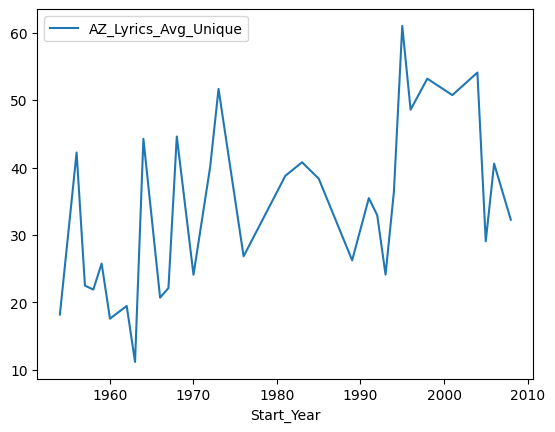

In [184]:
Wiki_Artists[(Wiki_Artists['AZ_Lyrics_Total_Unique'].notna())][['Start_Year','AZ_Lyrics_Avg_Unique']].groupby('Start_Year').aggregate({'AZ_Lyrics_Avg_Unique' : 'mean'}).plot()
Wiki_Artists[(Wiki_Artists['AZ_Lyrics_Total_Unique'].notna())][['Start_Year','AZ_Lyrics_Avg_Unique','AZ_Lyrics_Total_Unique']].corr()